In [1]:
import pandas as pd
import numpy as np
import flwr as fl
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import DirichletPartitioner, IidPartitioner
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from flwr.common import ndarrays_to_parameters, parameters_to_ndarrays
from sklearn.metrics import accuracy_score, log_loss, precision_score, recall_score
from common_fun import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from collections import OrderedDict
import time

In [2]:
partitions = FederatedDataset(
    dataset="scikit-learn/adult-census-income",
    partitioners={
        "train": IidPartitioner(num_partitions=1),
    }
)

print("Number of samples per Client ID (non-IID):")
show_num_samples_per_client(partitions, 1)

Number of samples per Client ID (non-IID):
Client 0 → 32561 samples


In [3]:
partitions.load_partition(0).to_pandas().columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income'],
      dtype='object')

In [4]:
partitions.load_partition(0).to_pandas()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,46,Private,321327,Some-college,10,Married-civ-spouse,Transport-moving,Husband,White,Male,7298,0,45,United-States,>50K
1,34,?,133861,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,0,0,25,United-States,<=50K
2,24,Private,289448,Assoc-voc,11,Never-married,Adm-clerical,Own-child,Asian-Pac-Islander,Female,0,0,40,Philippines,<=50K
3,33,Private,174789,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Male,0,0,50,United-States,<=50K
4,45,Self-emp-not-inc,34446,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,50,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,29,State-gov,71592,Some-college,10,Never-married,Adm-clerical,Unmarried,Asian-Pac-Islander,Female,0,0,40,Philippines,<=50K
32557,52,Private,94391,HS-grad,9,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,40,United-States,<=50K
32558,43,Self-emp-not-inc,34007,Bachelors,13,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,70,United-States,>50K
32559,38,Private,133963,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,50,United-States,>50K


In [5]:
pdf = preprocess_data(partitions.load_partition(0).to_pandas())

pdf

,age,education_num,capital_gain,capital_loss,hours_per_week,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,...,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,income_>50K
0,46,10,7298,0,45,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,24,11,0,0,40,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,33,10,0,0,50,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,45,9,0,0,50,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
5,36,9,0,0,40,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,29,10,0,0,40,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
32557,52,9,0,0,40,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32558,43,13,0,0,70,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
32559,38,13,0,0,50,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [6]:
X = pdf.drop('income_>50K', axis=1).values
y = pdf['income_>50K'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
print(f"Total training samples: {len(X_train)}")
print(f"Total testing samples: {len(X_test)}")

global_classes = np.unique(y_test)

Total training samples: 24129
Total testing samples: 6033


In [8]:
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 30

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [10]:
n_features = X_train.shape[1]

class Net(nn.Module):
    """A slightly larger MLP model."""
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(input_size, 128), # Wider first layer
            nn.ReLU(),
            nn.Dropout(0.2), # Add dropout for regularization
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.layer_stack(x)

# Instantiate the model to verify
model = Net(input_size=n_features)
print(model)

Net(
  (layer_stack): Sequential(
    (0): Linear(in_features=24, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [11]:
model = Net(input_size=n_features).to(device)

In [12]:
neg_count = np.sum(y_train == 0)
pos_count = np.sum(y_train == 1)
pos_weight_value = neg_count / pos_count if pos_count > 0 else 1.0
pos_weight_tensor = torch.tensor(pos_weight_value).to(device)

In [13]:
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [14]:
history = {
    "train_loss": [], "train_acc": [], "train_prec": [], "train_rec": [],
    "test_loss": [], "test_acc": [], "test_prec": [], "test_rec": []
}

In [15]:
# Create DataLoader
train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [16]:
print("\nStarting training with per-epoch evaluation...")

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    model.eval() 
    with torch.no_grad():
        # Training metrics
        train_outputs = model(train_loader.dataset.tensors[0].to(device))
        train_preds = torch.round(torch.sigmoid(train_outputs)).cpu().numpy()
        train_loss = criterion(train_outputs, train_loader.dataset.tensors[1].to(device)).item()
        history["train_loss"].append(train_loss)
        history["train_acc"].append(accuracy_score(y_train, train_preds))
        history["train_prec"].append(precision_score(y_train, train_preds, labels=[0, 1], zero_division=0))
        history["train_rec"].append(recall_score(y_train, train_preds, labels=[0, 1], zero_division=0))

        # Test metrics
        test_outputs = model(X_test_tensor)
        # prob = torch.sigmoid(test_outputs)
        # test_preds = (prob > 0.65).cpu().numpy()
        # test_preds = (prob > 0.5).float().cpu().numpy()  # Alternative way to get binary predictions
        test_preds = torch.round(torch.sigmoid(test_outputs)).cpu().numpy()
        test_loss = criterion(test_outputs, y_test_tensor.view(-1, 1).to(device)).item()
        history["test_loss"].append(test_loss)
        history["test_acc"].append(accuracy_score(y_test, test_preds))
        history["test_prec"].append(precision_score(y_test, test_preds, labels=[0, 1], zero_division=0))
        history["test_rec"].append(recall_score(y_test, test_preds, labels=[0, 1], zero_division=0))
        

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
            f"Train Loss: {history['train_loss'][-1]:.4f}, Train Acc: {history['train_acc'][-1]:.4f}, Train Recall: {history['train_rec'][-1]:.4f} | "
            f"Test Acc: {history['test_acc'][-1]:.4f}, Test Recall: {history['test_rec'][-1]:.4f}")

end_time = time.time()
print(f"Training finished in {end_time - start_time:.2f}s")


Starting training with per-epoch evaluation...


NameError: name 'epoch_loss' is not defined

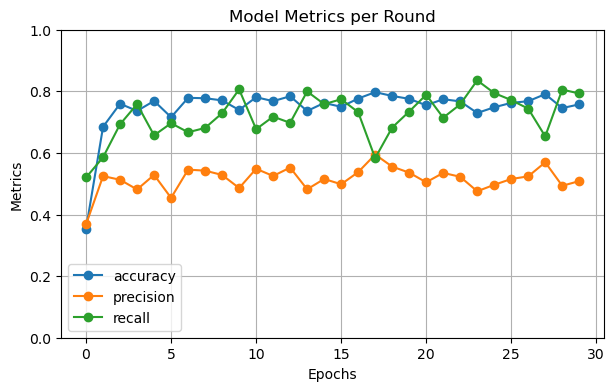

In [ ]:
fig_acc, ax_acc = plt.subplots(figsize=(7,4)) # Create a new figure for accuracy

ax_acc.plot(history['test_acc'], marker='o', linestyle='-', label='accuracy')

ax_acc.set_title("Model Metrics per Round")
ax_acc.set_xlabel("Epochs")
ax_acc.set_ylabel("Metrics")
ax_acc.grid(True)
ax_acc.legend()
ax_acc.set_ylim(0, 1)
plt.show()

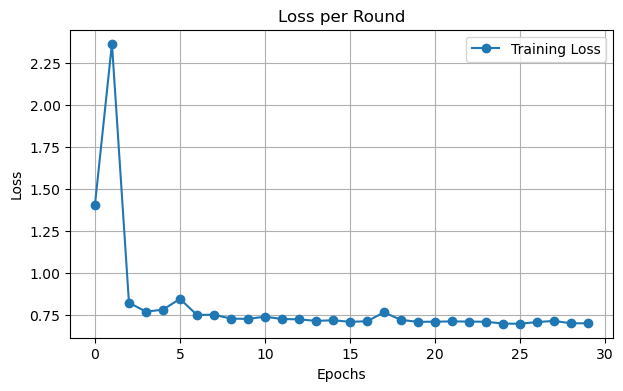

In [ ]:
fig_acc, ax = plt.subplots(figsize=(7,4)) # Create a new figure for accuracy


# ax_acc.plot(history['train_loss'], marker='o', linestyle='-', label='train_loss')
ax.plot(history['train_loss'], marker='o', linestyle='-', label='Training Loss')
ax.plot(history['test_loss'], marker='o', linestyle='-', label='Test Loss')
# ax.set_yscale('log')  # Use logarithmic scale for better visibility of loss values
ax.set_title("Loss per Round")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.grid(True)
ax.legend()
# ax_acc.set_ylim(0, 1)
plt.show()